In [ ]:
# Import des librairies.
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  
import scipy.stats as ss  
from statsmodels.stats.multicomp import MultiComparison
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import statsmodels.formula.api as smf 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import randint, uniform
import random
from functions import * 
import locale
import os
from tabulate import tabulate
import joblib

# Configuration du style de visualisation des graphiques avec un style personnalisé
plt.style.use("https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle")
# Configuration pour l'affichage des nombres à virgule flottante
pd.options.display.float_format = '{:.4f}'.format

# 1. Importation, exploration et nettoyage des donnees

In [2]:
df_synth = pd.read_csv("../00 - Annexes/data_prepro/donnees_synthetiques.csv")
df_validation = pd.read_csv("../00 - Annexes/data_prepro/donnees_validation.csv")

## 1.1. **EDA**

In [3]:
# Affichage des premières lignes et observation de la forme du DataFrame.
print(df_synth.shape)
df_synth.head()

(108000, 18)


,Categorie,SKU,PrixInitial,DateLancement,AgeProduitEnJours,Date,Timestamp,Prix,PrixPlancher,PlancherPourcentage,Promotion,QuantiteVendue,ProbabiliteAchat,UtiliteProduit,ElasticitePrix,Remise,ErreurAleatoire,Qualite
0,Electronique,SKU1_1,423.0096,2023-01-01,0,2023-01-01,2023-01-01 00:00:00,423.9115,169.2039,0.4000,0,0,0.0000,-21.7110,0.0531,0.0000,0.9019,0.5306
1,Electronique,SKU1_1,423.0096,2023-01-01,0,2023-01-01,2023-01-01 08:00:00,423.1837,169.2039,0.4000,0,0,0.0000,-23.3625,0.0531,0.0000,0.1740,0.5306
2,Electronique,SKU1_1,423.0096,2023-01-01,0,2023-01-01,2023-01-01 16:00:00,422.9667,169.2039,0.4000,0,0,0.0000,-21.8094,0.0531,0.0000,-0.0429,0.5306
3,Electronique,SKU1_1,423.0096,2023-01-01,1,2023-01-02,2023-01-02 00:00:00,422.4291,169.2039,0.4000,0,0,0.0000,-22.3498,0.0531,0.0000,0.0535,0.5306
4,Electronique,SKU1_1,423.0096,2023-01-01,1,2023-01-02,2023-01-02 08:00:00,422.7658,169.2039,0.4000,0,0,0.0000,-23.4104,0.0531,0.0000,0.3902,0.5306


In [4]:
df_synth.drop(columns=['DateLancement', 'PrixPlancher', 'PlancherPourcentage','ErreurAleatoire'], inplace=True)

df_validation.drop(columns=['DateLancement', 'PrixPlancher', 'PlancherPourcentage','ErreurAleatoire'], inplace=True)

In [5]:
# Affichage de statistiques descriptives sur le DataFrame.
df_synth.describe()


,PrixInitial,AgeProduitEnJours,Prix,Promotion,QuantiteVendue,ProbabiliteAchat,UtiliteProduit,ElasticitePrix,Remise,Qualite
count,108000.0000,108000.0000,108000.0000,108000.0000,108000.0000,108000.0000,108000.0000,108000.0000,108000.0000,108000.0000
mean,174.2819,299.5000,117.7156,0.0981,0.2748,0.0402,-9.7139,0.0509,0.0098,0.4896
std,192.3183,173.2056,131.5709,0.2974,0.8095,0.0882,7.0602,0.0047,0.0297,0.3105
min,17.4571,0.0000,10.4579,0.0000,0.0000,0.0000,-30.0688,0.0052,0.0000,0.0157
25%,30.2157,149.7500,25.4214,0.0000,0.0000,0.0000,-16.2638,0.0511,0.0000,0.1552
50%,51.1244,299.5000,38.3852,0.0000,0.0000,0.0003,-8.0359,0.0530,0.0000,0.5258
75%,411.5271,449.2500,223.8128,0.0000,0.0000,0.0376,-3.2583,0.0531,0.0000,0.7719
max,530.2182,599.0000,530.7635,1.0000,12.0000,0.9019,2.2186,0.0531,0.1000,0.9844


In [6]:
# Vérification des types de données et de la présence de valeurs NaN.
df_synth.info()

df_synth.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108000 entries, 0 to 107999
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Categorie          108000 non-null  object 
 1   SKU                108000 non-null  object 
 2   PrixInitial        108000 non-null  float64
 3   AgeProduitEnJours  108000 non-null  int64  
 4   Date               108000 non-null  object 
 5   Timestamp          108000 non-null  object 
 6   Prix               108000 non-null  float64
 7   Promotion          108000 non-null  int64  
 8   QuantiteVendue     108000 non-null  int64  
 9   ProbabiliteAchat   108000 non-null  float64
 10  UtiliteProduit     108000 non-null  float64
 11  ElasticitePrix     108000 non-null  float64
 12  Remise             108000 non-null  float64
 13  Qualite            108000 non-null  float64
dtypes: float64(7), int64(3), object(4)
memory usage: 11.5+ MB


Categorie            0
SKU                  0
PrixInitial          0
AgeProduitEnJours    0
Date                 0
Timestamp            0
Prix                 0
Promotion            0
QuantiteVendue       0
ProbabiliteAchat     0
UtiliteProduit       0
ElasticitePrix       0
Remise               0
Qualite              0
dtype: int64

In [7]:
# Transformation des types
df_synth['Categorie'] = df_synth['Categorie'].astype('category')
df_synth['SKU'] = df_synth['SKU'].astype('string')
df_synth['PrixInitial'] = df_synth['PrixInitial'].astype('float64')
df_synth['AgeProduitEnJours'] = df_synth['AgeProduitEnJours'].astype('int64')
df_synth['Date'] = pd.to_datetime(df_synth['Date'])  # La date seule
df_synth['Timestamp'] = pd.to_datetime(df_synth['Timestamp'])  # Les timestamps précis
df_synth['Prix'] = df_synth['Prix'].astype('float64')
df_synth['Promotion'] = df_synth['Promotion'].astype('bool')
df_synth['QuantiteVendue'] = df_synth['QuantiteVendue'].astype('int64')
df_synth['ProbabiliteAchat'] = df_synth['ProbabiliteAchat'].astype('float64')
df_synth['UtiliteProduit'] = df_synth['UtiliteProduit'].astype('float64')
df_synth['ElasticitePrix'] = df_synth['ElasticitePrix'].astype('float64')
df_synth['Remise'] = df_synth['Remise'].astype('float64')
df_synth['Qualite'] = df_synth['Qualite'].astype('float64')


In [8]:
# Transformation des types
df_validation['Categorie'] = df_validation['Categorie'].astype('category')
df_validation['SKU'] = df_validation['SKU'].astype('string')
df_validation['PrixInitial'] = df_validation['PrixInitial'].astype('float64')
df_validation['AgeProduitEnJours'] = df_validation['AgeProduitEnJours'].astype('int64')
df_validation['Date'] = pd.to_datetime(df_validation['Date'])  # La date seule
df_validation['Timestamp'] = pd.to_datetime(df_validation['Timestamp'])  # Les timestamps précis
df_validation['Prix'] = df_validation['Prix'].astype('float64')
df_validation['Promotion'] = df_validation['Promotion'].astype('bool')
df_validation['QuantiteVendue'] = df_validation['QuantiteVendue'].astype('int64')
df_validation['ProbabiliteAchat'] = df_validation['ProbabiliteAchat'].astype('float64')
df_validation['UtiliteProduit'] = df_validation['UtiliteProduit'].astype('float64')
df_validation['ElasticitePrix'] = df_validation['ElasticitePrix'].astype('float64')
df_validation['Remise'] = df_validation['Remise'].astype('float64')
df_validation['Qualite'] = df_validation['Qualite'].astype('float64')

In [9]:
# Recherche de lignes entièrement dupliquées. 
print(df_synth.duplicated().sum())

0


#### Observations :


* Le DataFrame est composé de 108000 lignes et 18 colonnes.

* Il n'y a pas de valeurs *NaN*.

* Il n'y a pas de lignes dupliquées.


***



=== Analyse pour la catégorie 'Electronique' ===

Analyse univariée pour la variable 'SKU':
La variable 'SKU' n'est ni numérique ni catégorielle et n'a pas été analysée.


Analyse univariée pour la variable 'PrixInitial':
╒═════════════╤═════════╤═════════╤════════╤═════════╤═════════╤════════╤═════════╤═════════╤════════════╤════════════╕
│             │   count │    mean │    std │     min │     25% │    50% │     75% │     max │       skew │   kurtosis │
╞═════════════╪═════════╪═════════╪════════╪═════════╪═════════╪════════╪═════════╪═════════╪════════════╪════════════╡
│ PrixInitial │   36000 │ 443.588 │ 41.582 │ 361.917 │ 419.182 │ 445.51 │ 468.927 │ 530.218 │ -0.0754148 │  -0.283138 │
╘═════════════╧═════════╧═════════╧════════╧═════════╧═════════╧════════╧═════════╧═════════╧════════════╧════════════╛


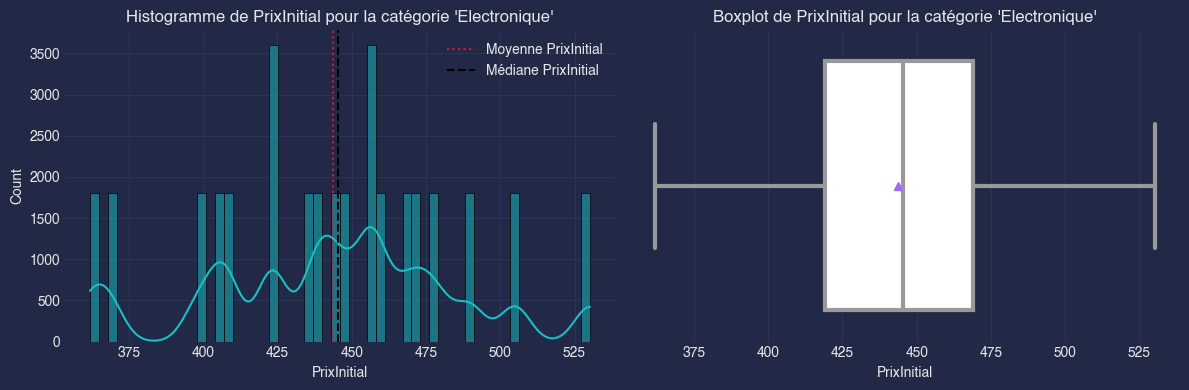



Analyse univariée pour la variable 'AgeProduitEnJours':
╒═══════════════════╤═════════╤════════╤═════════╤═══════╤════════╤═══════╤════════╤═══════╤════════╤════════════╕
│                   │   count │   mean │     std │   min │    25% │   50% │    75% │   max │   skew │   kurtosis │
╞═══════════════════╪═════════╪════════╪═════════╪═══════╪════════╪═══════╪════════╪═══════╪════════╪════════════╡
│ AgeProduitEnJours │   36000 │  299.5 │ 173.207 │     0 │ 149.75 │ 299.5 │ 449.25 │   599 │      0 │   -1.20001 │
╘═══════════════════╧═════════╧════════╧═════════╧═══════╧════════╧═══════╧════════╧═══════╧════════╧════════════╛


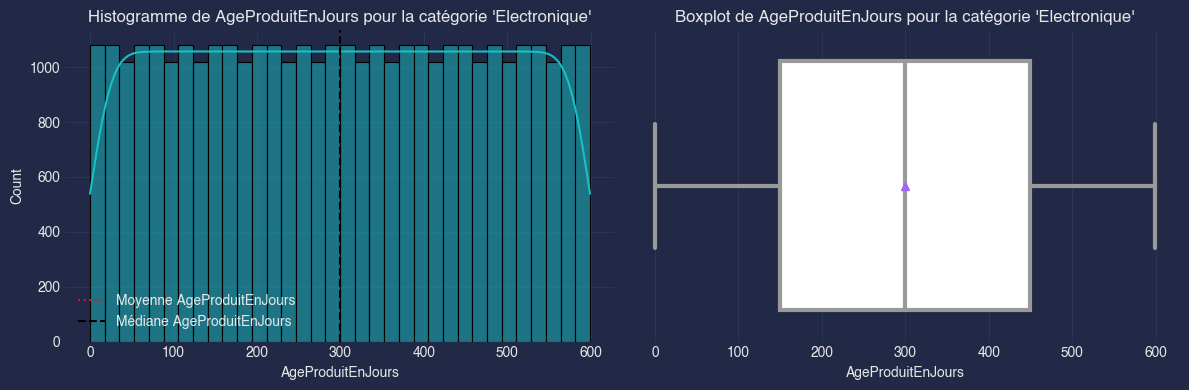



Analyse univariée pour la variable 'Date':
La variable 'Date' n'est ni numérique ni catégorielle et n'a pas été analysée.


Analyse univariée pour la variable 'Timestamp':
La variable 'Timestamp' n'est ni numérique ni catégorielle et n'a pas été analysée.


Analyse univariée pour la variable 'Prix':
╒══════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤══════════╤════════════╕
│      │   count │    mean │     std │     min │     25% │     50% │     75% │     max │     skew │   kurtosis │
╞══════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪══════════╪════════════╡
│ Prix │   36000 │ 291.298 │ 80.5321 │ 144.767 │ 223.818 │ 280.549 │ 351.408 │ 530.764 │ 0.433096 │  -0.694577 │
╘══════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╧══════════╧════════════╛


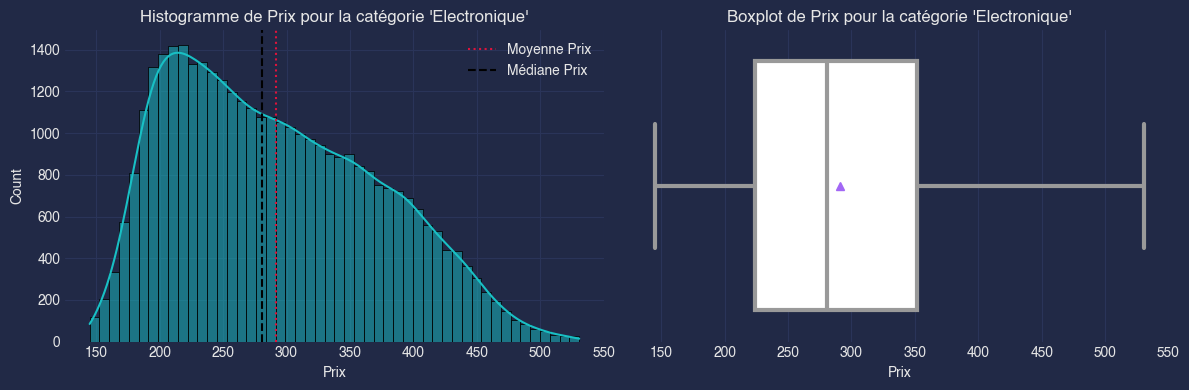



Analyse univariée pour la variable 'Promotion':
╒═══════════╤═════════╤══════════╤═══════╤════════╤═════════╤════════════╕
│           │   count │   unique │   top │   freq │    skew │   kurtosis │
╞═══════════╪═════════╪══════════╪═══════╪════════╪═════════╪════════════╡
│ Promotion │   36000 │        2 │     0 │  34229 │ 4.16902 │    15.3815 │
╘═══════════╧═════════╧══════════╧═══════╧════════╧═════════╧════════════╛


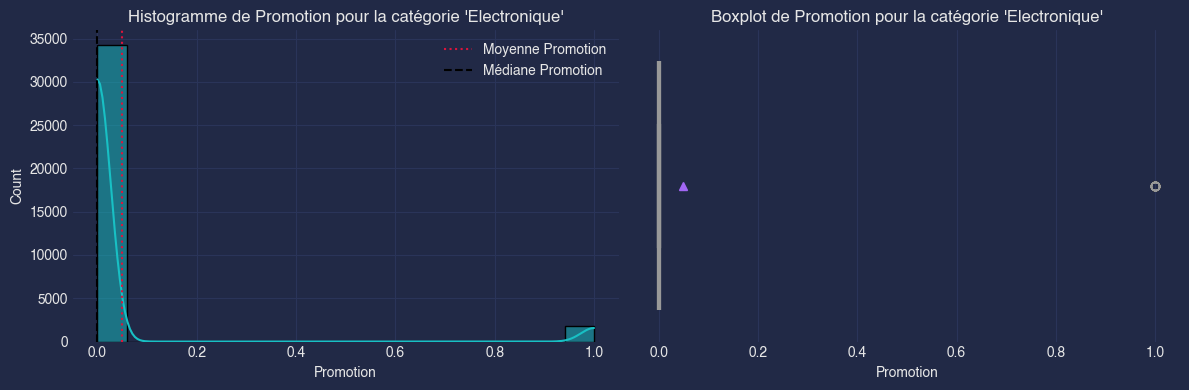



Analyse univariée pour la variable 'QuantiteVendue':
╒════════════════╤═════════╤════════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤════════╤════════════╕
│                │   count │   mean │   std │   min │   25% │   50% │   75% │   max │   skew │   kurtosis │
╞════════════════╪═════════╪════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪════════╪════════════╡
│ QuantiteVendue │   36000 │      0 │     0 │     0 │     0 │     0 │     0 │     0 │      0 │          0 │
╘════════════════╧═════════╧════════╧═══════╧═══════╧═══════╧═══════╧═══════╧═══════╧════════╧════════════╛


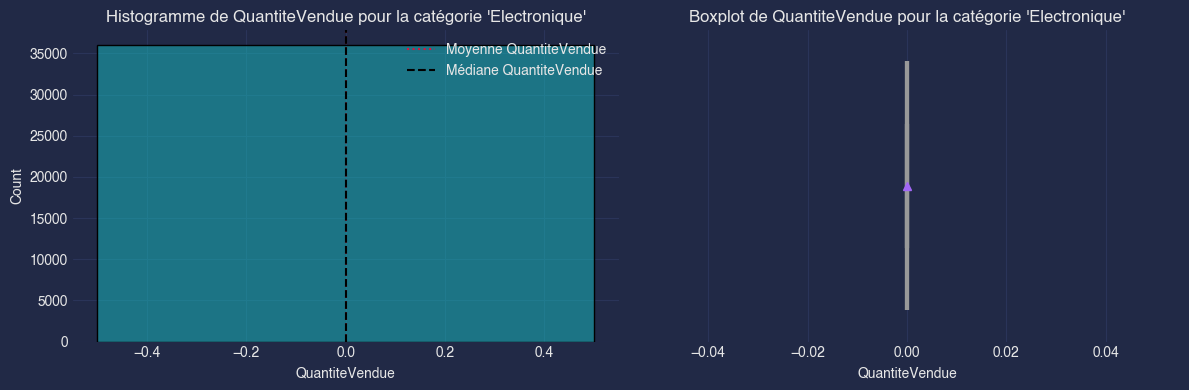



Analyse univariée pour la variable 'ProbabiliteAchat':
╒══════════════════╤═════════╤═════════════╤═════════════╤═════════════╤═════════════╤═════════════╤═════════════╤═════════════╤═════════╤════════════╕
│                  │   count │        mean │         std │         min │         25% │         50% │         75% │         max │    skew │   kurtosis │
╞══════════════════╪═════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════╪════════════╡
│ ProbabiliteAchat │   36000 │ 1.31188e-07 │ 4.27126e-07 │ 8.73557e-14 │ 1.55177e-09 │ 1.57606e-08 │ 8.89341e-08 │ 1.81755e-05 │ 11.3211 │     241.06 │
╘══════════════════╧═════════╧═════════════╧═════════════╧═════════════╧═════════════╧═════════════╧═════════════╧═════════════╧═════════╧════════════╛


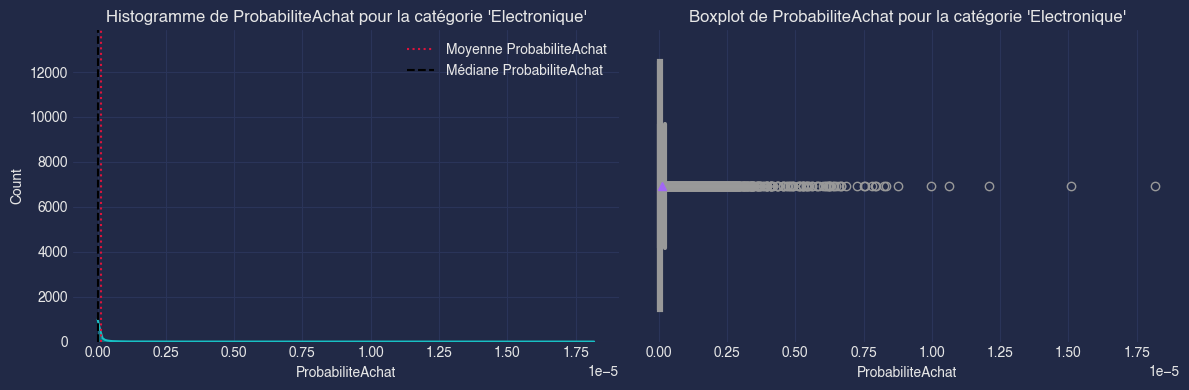



Analyse univariée pour la variable 'UtiliteProduit':
╒════════════════╤═════════╤══════════╤═════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤════════════╕
│                │   count │     mean │     std │      min │      25% │      50% │      75% │      max │     skew │   kurtosis │
╞════════════════╪═════════╪══════════╪═════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪════════════╡
│ UtiliteProduit │   36000 │ -18.4356 │ 2.92103 │ -30.0688 │ -20.2925 │ -18.0033 │ -16.2627 │ -10.9154 │ -0.58383 │ -0.0266689 │
╘════════════════╧═════════╧══════════╧═════════╧══════════╧══════════╧══════════╧══════════╧══════════╧══════════╧════════════╛


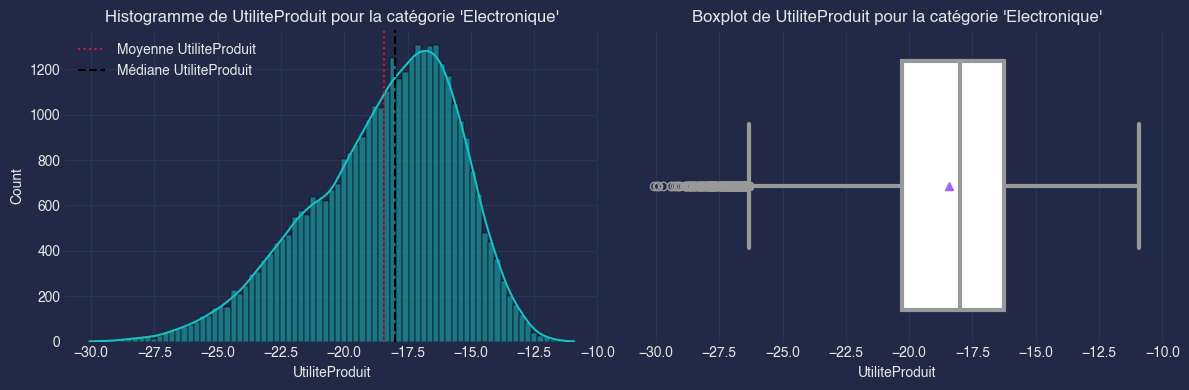



Analyse univariée pour la variable 'ElasticitePrix':
╒════════════════╤═════════╤══════════╤═════════════╤══════════╤══════════╤══════════╤══════════╤══════════╤════════╤════════════╕
│                │   count │     mean │         std │      min │      25% │      50% │      75% │      max │   skew │   kurtosis │
╞════════════════╪═════════╪══════════╪═════════════╪══════════╪══════════╪══════════╪══════════╪══════════╪════════╪════════════╡
│ ElasticitePrix │   36000 │ 0.053059 │ 2.26629e-08 │ 0.053058 │ 0.053059 │ 0.053059 │ 0.053059 │ 0.053059 │      0 │     241.06 │
╘════════════════╧═════════╧══════════╧═════════════╧══════════╧══════════╧══════════╧══════════╧══════════╧════════╧════════════╛


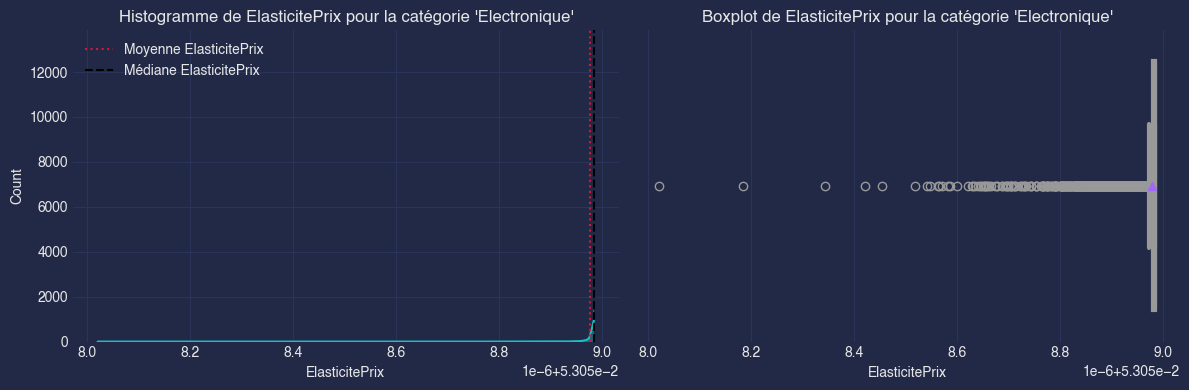



Analyse univariée pour la variable 'Remise':
╒════════╤═════════╤════════════╤═══════════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════╤════════════╕
│        │   count │       mean │       std │   min │   25% │   50% │   75% │   max │    skew │   kurtosis │
╞════════╪═════════╪════════════╪═══════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═════════╪════════════╡
│ Remise │   36000 │ 0.00491944 │ 0.0216277 │     0 │     0 │     0 │     0 │   0.1 │ 4.16902 │    15.3815 │
╘════════╧═════════╧════════════╧═══════════╧═══════╧═══════╧═══════╧═══════╧═══════╧═════════╧════════════╛


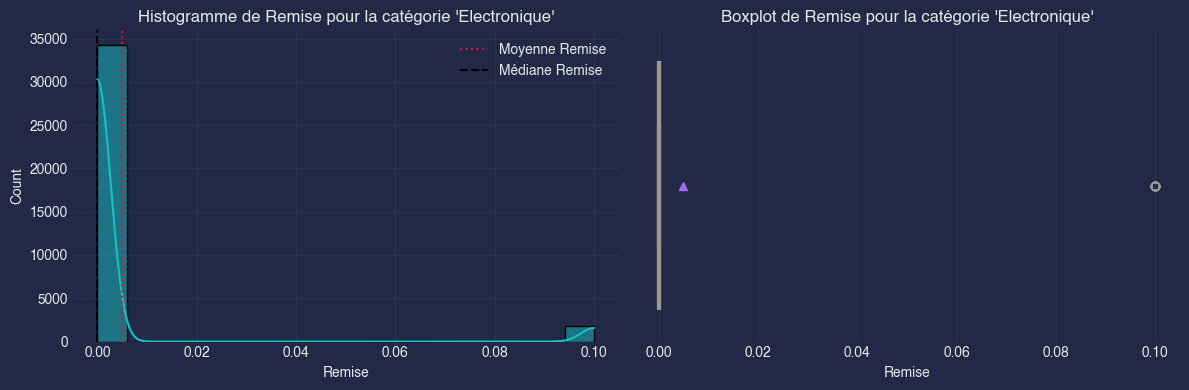



Analyse univariée pour la variable 'Qualite':
╒═════════╤═════════╤══════════╤══════════╤═══════════╤══════════╤════════╤══════════╤══════════╤═════════╤════════════╕
│         │   count │     mean │      std │       min │      25% │    50% │      75% │      max │    skew │   kurtosis │
╞═════════╪═════════╪══════════╪══════════╪═══════════╪══════════╪════════╪══════════╪══════════╪═════════╪════════════╡
│ Qualite │   36000 │ 0.428964 │ 0.291926 │ 0.0552414 │ 0.137546 │ 0.4442 │ 0.653397 │ 0.887982 │ 0.12631 │   -1.44324 │
╘═════════╧═════════╧══════════╧══════════╧═══════════╧══════════╧════════╧══════════╧══════════╧═════════╧════════════╛


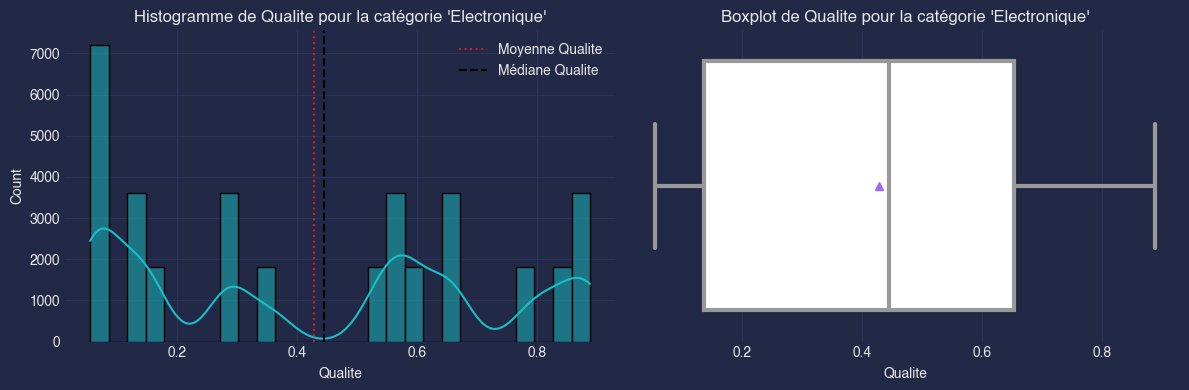





=== Analyse pour la catégorie 'Livres' ===

Analyse univariée pour la variable 'SKU':
La variable 'SKU' n'est ni numérique ni catégorielle et n'a pas été analysée.


Analyse univariée pour la variable 'PrixInitial':
╒═════════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═══════╤═════════╤═══════════╤════════════╕
│             │   count │    mean │     std │     min │     25% │     50% │   75% │     max │      skew │   kurtosis │
╞═════════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═══════╪═════════╪═══════════╪════════════╡
│ PrixInitial │   36000 │ 26.2824 │ 4.72516 │ 17.4571 │ 22.3944 │ 28.3531 │ 29.91 │ 33.7995 │ -0.461527 │   -1.02788 │
╘═════════════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╧═══════╧═════════╧═══════════╧════════════╛


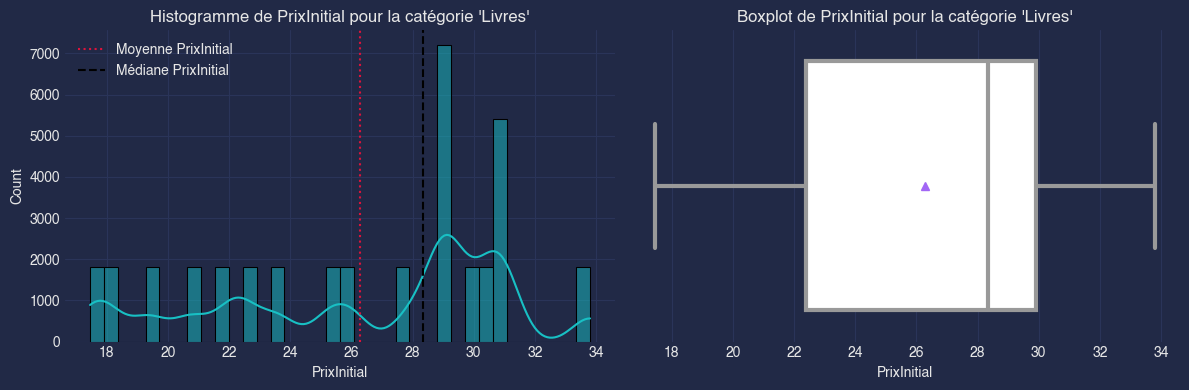



Analyse univariée pour la variable 'AgeProduitEnJours':
╒═══════════════════╤═════════╤════════╤═════════╤═══════╤════════╤═══════╤════════╤═══════╤════════╤════════════╕
│                   │   count │   mean │     std │   min │    25% │   50% │    75% │   max │   skew │   kurtosis │
╞═══════════════════╪═════════╪════════╪═════════╪═══════╪════════╪═══════╪════════╪═══════╪════════╪════════════╡
│ AgeProduitEnJours │   36000 │  299.5 │ 173.207 │     0 │ 149.75 │ 299.5 │ 449.25 │   599 │      0 │   -1.20001 │
╘═══════════════════╧═════════╧════════╧═════════╧═══════╧════════╧═══════╧════════╧═══════╧════════╧════════════╛


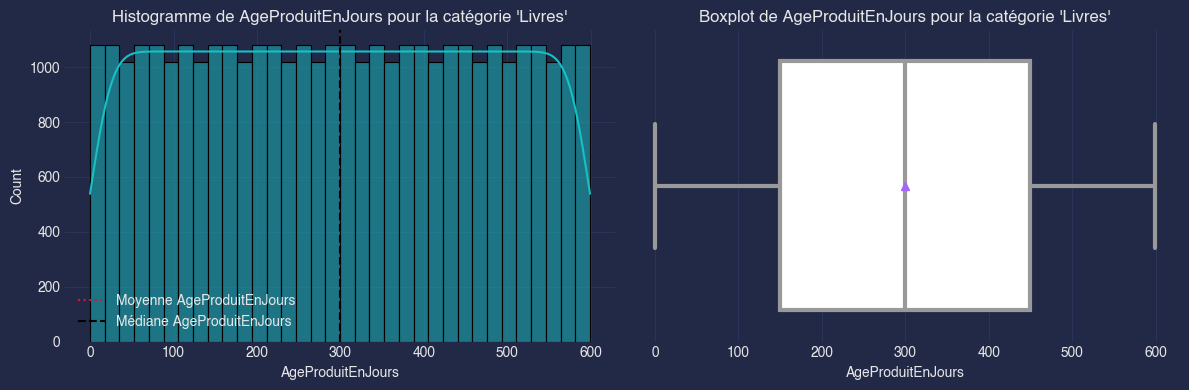



Analyse univariée pour la variable 'Date':
La variable 'Date' n'est ni numérique ni catégorielle et n'a pas été analysée.


Analyse univariée pour la variable 'Timestamp':
La variable 'Timestamp' n'est ni numérique ni catégorielle et n'a pas été analysée.


Analyse univariée pour la variable 'Prix':
╒══════╤═════════╤════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═══════════╤════════════╕
│      │   count │   mean │     std │     min │     25% │     50% │     75% │     max │      skew │   kurtosis │
╞══════╪═════════╪════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═══════════╪════════════╡
│ Prix │   36000 │ 22.377 │ 4.57524 │ 10.4579 │ 18.7894 │ 22.7767 │ 25.8294 │ 34.9406 │ -0.115785 │  -0.763953 │
╘══════╧═════════╧════════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╧═══════════╧════════════╛


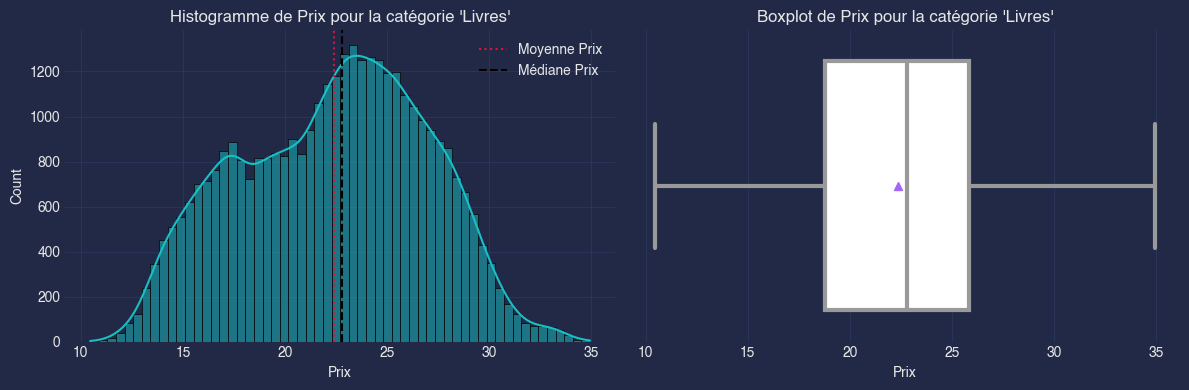



Analyse univariée pour la variable 'Promotion':
╒═══════════╤═════════╤══════════╤═══════╤════════╤═════════╤════════════╕
│           │   count │   unique │   top │   freq │    skew │   kurtosis │
╞═══════════╪═════════╪══════════╪═══════╪════════╪═════════╪════════════╡
│ Promotion │   36000 │        2 │     0 │  30686 │ 1.98697 │    1.94817 │
╘═══════════╧═════════╧══════════╧═══════╧════════╧═════════╧════════════╛


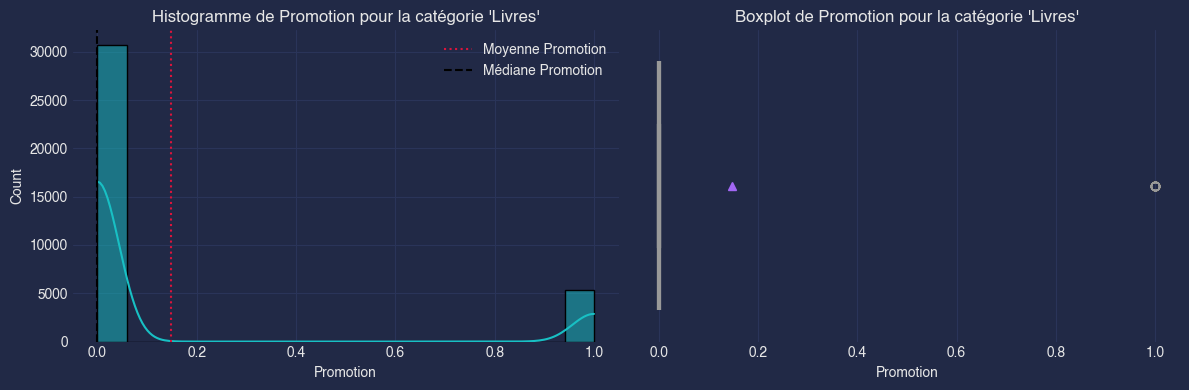



Analyse univariée pour la variable 'QuantiteVendue':
╒════════════════╤═════════╤══════════╤═════════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════╤════════════╕
│                │   count │     mean │     std │   min │   25% │   50% │   75% │   max │    skew │   kurtosis │
╞════════════════╪═════════╪══════════╪═════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═════════╪════════════╡
│ QuantiteVendue │   36000 │ 0.778306 │ 1.23229 │     0 │     0 │     0 │     1 │    12 │ 2.35081 │    7.62352 │
╘════════════════╧═════════╧══════════╧═════════╧═══════╧═══════╧═══════╧═══════╧═══════╧═════════╧════════════╛


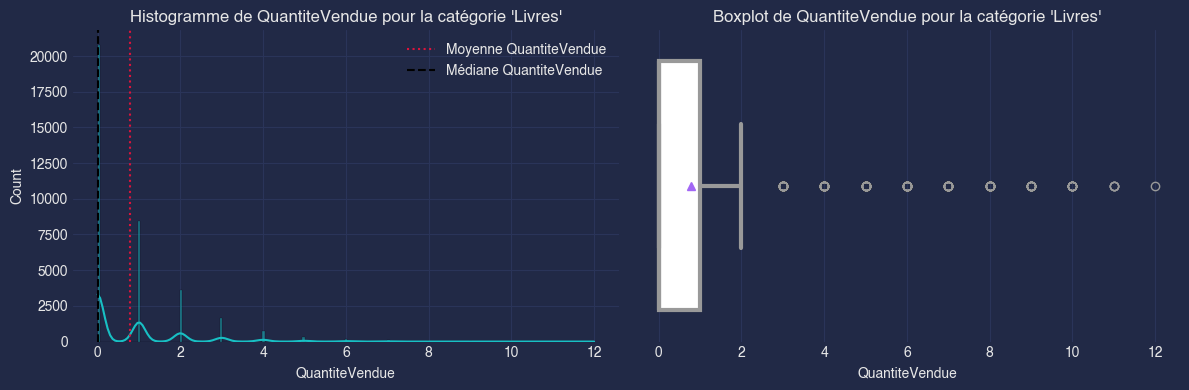



Analyse univariée pour la variable 'ProbabiliteAchat':
╒══════════════════╤═════════╤══════════╤══════════╤═════════════╤═══════════╤═══════════╤══════════╤══════════╤════════╤════════════╕
│                  │   count │     mean │      std │         min │       25% │       50% │      75% │      max │   skew │   kurtosis │
╞══════════════════╪═════════╪══════════╪══════════╪═════════════╪═══════════╪═══════════╪══════════╪══════════╪════════╪════════════╡
│ ProbabiliteAchat │   36000 │ 0.111233 │ 0.121862 │ 0.000350939 │ 0.0290614 │ 0.0670394 │ 0.147548 │ 0.901905 │ 2.0801 │    5.06336 │
╘══════════════════╧═════════╧══════════╧══════════╧═════════════╧═══════════╧═══════════╧══════════╧══════════╧════════╧════════════╛


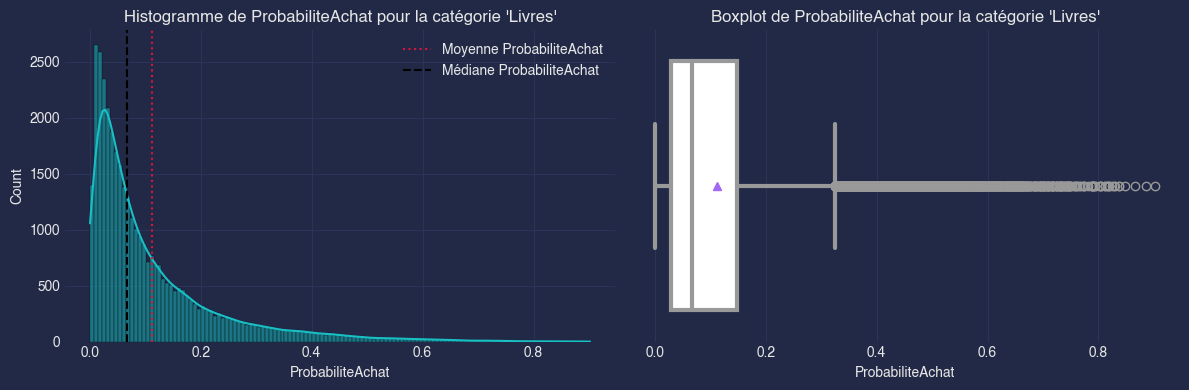



Analyse univariée pour la variable 'UtiliteProduit':
╒════════════════╤═════════╤══════════╤═════════╤══════════╤══════════╤══════════╤══════════╤═════════╤═══════════╤════════════╕
│                │   count │     mean │     std │      min │      25% │      50% │      75% │     max │      skew │   kurtosis │
╞════════════════╪═════════╪══════════╪═════════╪══════════╪══════════╪══════════╪══════════╪═════════╪═══════════╪════════════╡
│ UtiliteProduit │   36000 │ -2.65359 │ 1.27837 │ -7.95455 │ -3.53243 │ -2.65806 │ -1.77557 │ 2.21857 │ 0.0160427 │  -0.156535 │
╘════════════════╧═════════╧══════════╧═════════╧══════════╧══════════╧══════════╧══════════╧═════════╧═══════════╧════════════╛


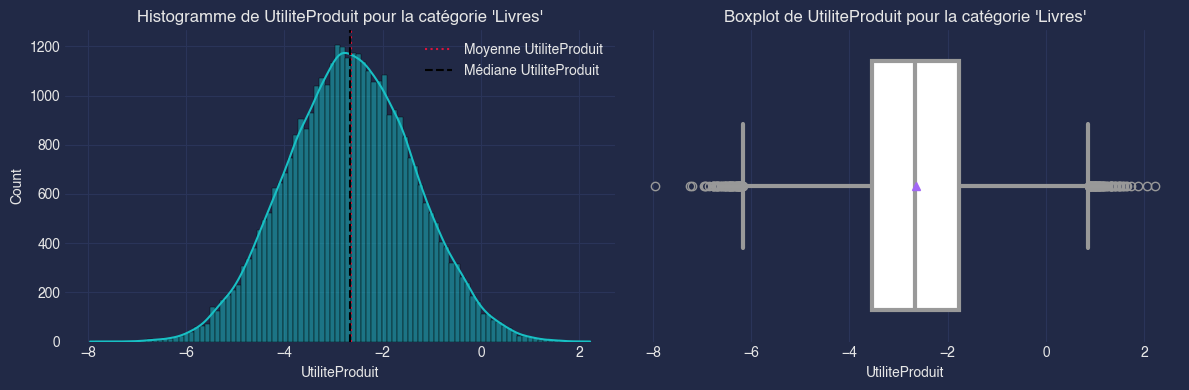



Analyse univariée pour la variable 'ElasticitePrix':
╒════════════════╤═════════╤═══════════╤════════════╤════════════╤═══════════╤═══════════╤══════════╤═══════════╤═════════╤════════════╕
│                │   count │      mean │        std │        min │       25% │       50% │      75% │       max │    skew │   kurtosis │
╞════════════════╪═════════╪═══════════╪════════════╪════════════╪═══════════╪═══════════╪══════════╪═══════════╪═════════╪════════════╡
│ ElasticitePrix │   36000 │ 0.0471571 │ 0.00646587 │ 0.00520483 │ 0.0452302 │ 0.0495019 │ 0.051517 │ 0.0530404 │ -2.0801 │    5.06336 │
╘════════════════╧═════════╧═══════════╧════════════╧════════════╧═══════════╧═══════════╧══════════╧═══════════╧═════════╧════════════╛


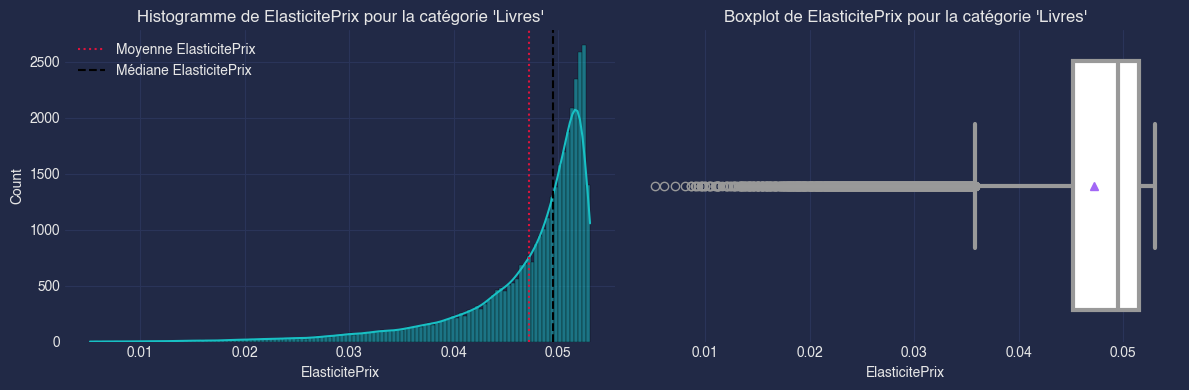



Analyse univariée pour la variable 'Remise':
╒════════╤═════════╤═══════════╤═══════════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════╤════════════╕
│        │   count │      mean │       std │   min │   25% │   50% │   75% │   max │    skew │   kurtosis │
╞════════╪═════════╪═══════════╪═══════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═════════╪════════════╡
│ Remise │   36000 │ 0.0147611 │ 0.0354719 │     0 │     0 │     0 │     0 │   0.1 │ 1.98697 │    1.94817 │
╘════════╧═════════╧═══════════╧═══════════╧═══════╧═══════╧═══════╧═══════╧═══════╧═════════╧════════════╛


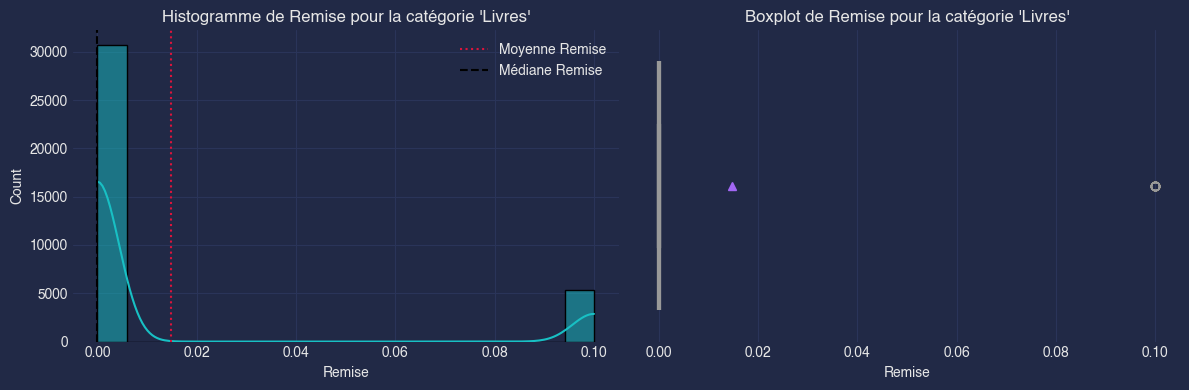



Analyse univariée pour la variable 'Qualite':
╒═════════╤═════════╤═════════╤═════════╤═══════════╤══════════╤══════════╤═════════╤══════════╤═══════════╤════════════╕
│         │   count │    mean │     std │       min │      25% │      50% │     75% │      max │      skew │   kurtosis │
╞═════════╪═════════╪═════════╪═════════╪═══════════╪══════════╪══════════╪═════════╪══════════╪═══════════╪════════════╡
│ Qualite │   36000 │ 0.51885 │ 0.31971 │ 0.0156962 │ 0.210772 │ 0.619245 │ 0.74973 │ 0.984384 │ -0.273106 │   -1.29592 │
╘═════════╧═════════╧═════════╧═════════╧═══════════╧══════════╧══════════╧═════════╧══════════╧═══════════╧════════════╛


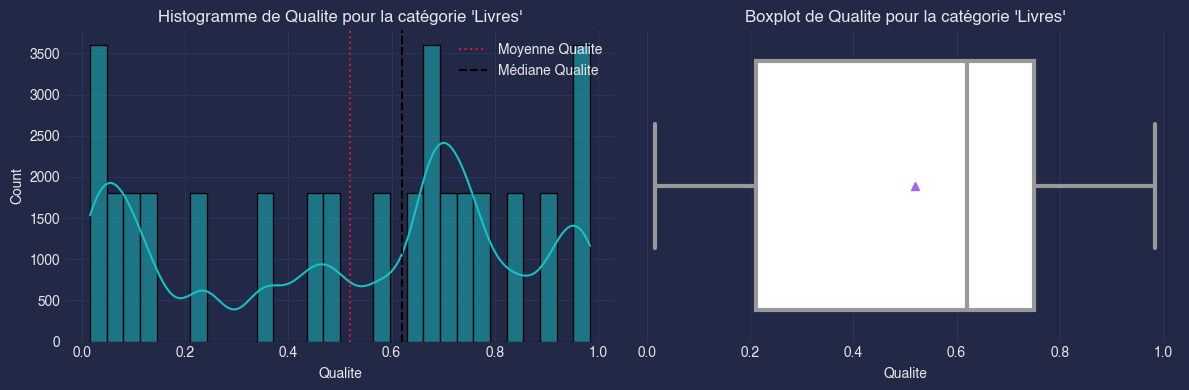





=== Analyse pour la catégorie 'Vetements' ===

Analyse univariée pour la variable 'SKU':
La variable 'SKU' n'est ni numérique ni catégorielle et n'a pas été analysée.


Analyse univariée pour la variable 'PrixInitial':
╒═════════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤════════╤═════════╤══════════╤════════════╕
│             │   count │    mean │     std │     min │     25% │     50% │    75% │     max │     skew │   kurtosis │
╞═════════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪════════╪═════════╪══════════╪════════════╡
│ PrixInitial │   36000 │ 52.9751 │ 7.84449 │ 38.2194 │ 48.8075 │ 51.1244 │ 56.291 │ 72.5734 │ 0.578113 │   0.361329 │
╘═════════════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╧════════╧═════════╧══════════╧════════════╛


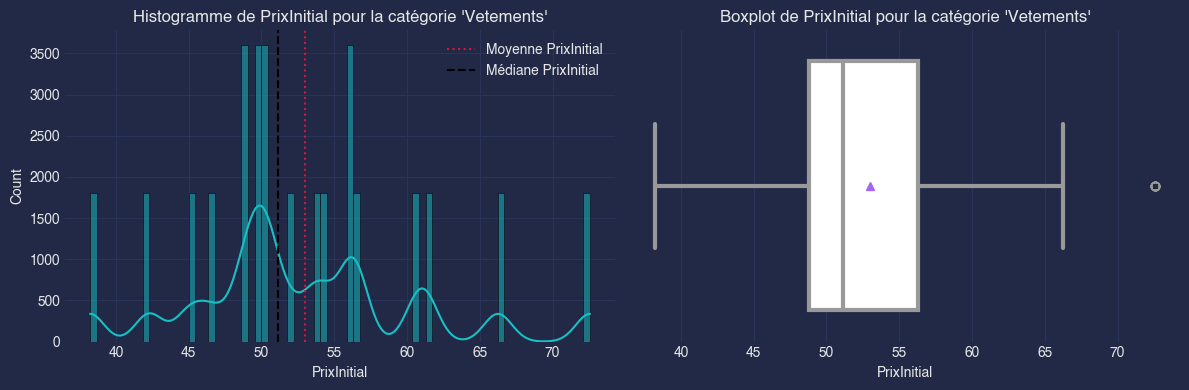



Analyse univariée pour la variable 'AgeProduitEnJours':
╒═══════════════════╤═════════╤════════╤═════════╤═══════╤════════╤═══════╤════════╤═══════╤════════╤════════════╕
│                   │   count │   mean │     std │   min │    25% │   50% │    75% │   max │   skew │   kurtosis │
╞═══════════════════╪═════════╪════════╪═════════╪═══════╪════════╪═══════╪════════╪═══════╪════════╪════════════╡
│ AgeProduitEnJours │   36000 │  299.5 │ 173.207 │     0 │ 149.75 │ 299.5 │ 449.25 │   599 │      0 │   -1.20001 │
╘═══════════════════╧═════════╧════════╧═════════╧═══════╧════════╧═══════╧════════╧═══════╧════════╧════════════╛


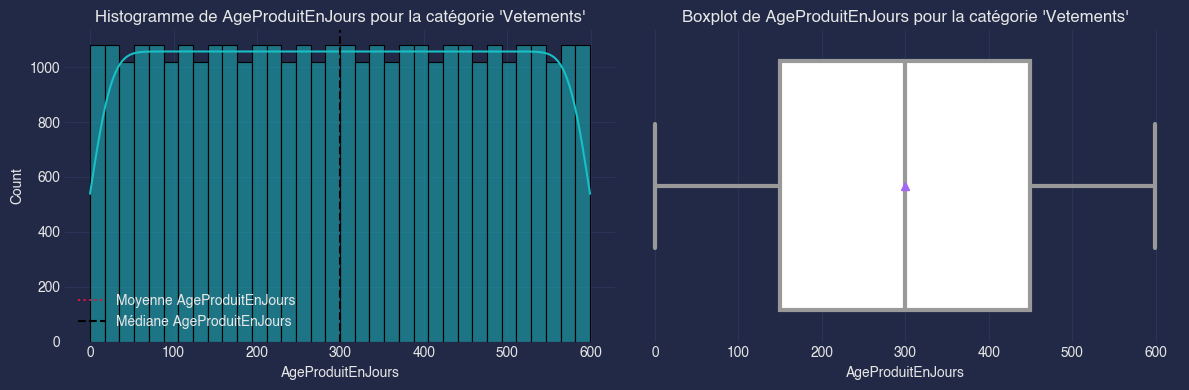



Analyse univariée pour la variable 'Date':
La variable 'Date' n'est ni numérique ni catégorielle et n'a pas été analysée.


Analyse univariée pour la variable 'Timestamp':
La variable 'Timestamp' n'est ni numérique ni catégorielle et n'a pas été analysée.


Analyse univariée pour la variable 'Prix':
╒══════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤══════════╤════════════╕
│      │   count │    mean │     std │     min │     25% │     50% │     75% │     max │     skew │   kurtosis │
╞══════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪══════════╪════════════╡
│ Prix │   36000 │ 39.4714 │ 9.13606 │ 19.1097 │ 32.5429 │ 38.3852 │ 45.3687 │ 73.2902 │ 0.595174 │    0.19231 │
╘══════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╧══════════╧════════════╛


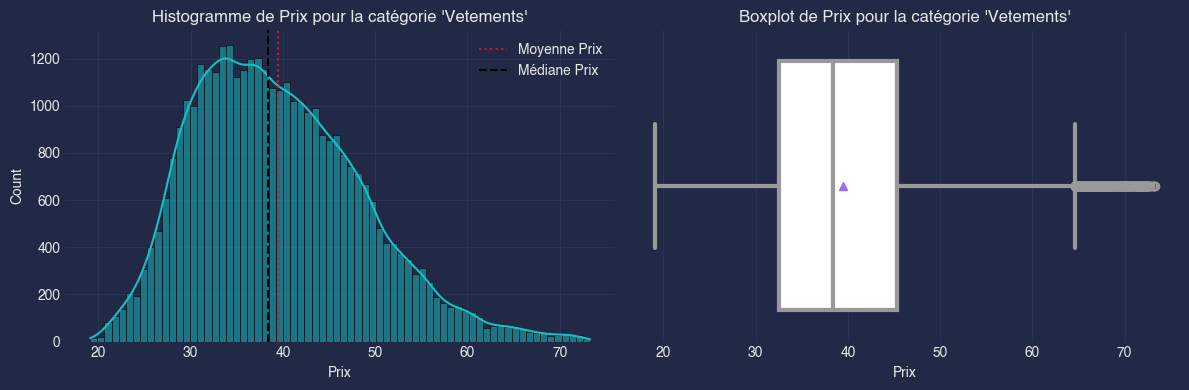



Analyse univariée pour la variable 'Promotion':
╒═══════════╤═════════╤══════════╤═══════╤════════╤════════╤════════════╕
│           │   count │   unique │   top │   freq │   skew │   kurtosis │
╞═══════════╪═════════╪══════════╪═══════╪════════╪════════╪════════════╡
│ Promotion │   36000 │        2 │     0 │  32491 │ 2.7144 │    5.36824 │
╘═══════════╧═════════╧══════════╧═══════╧════════╧════════╧════════════╛


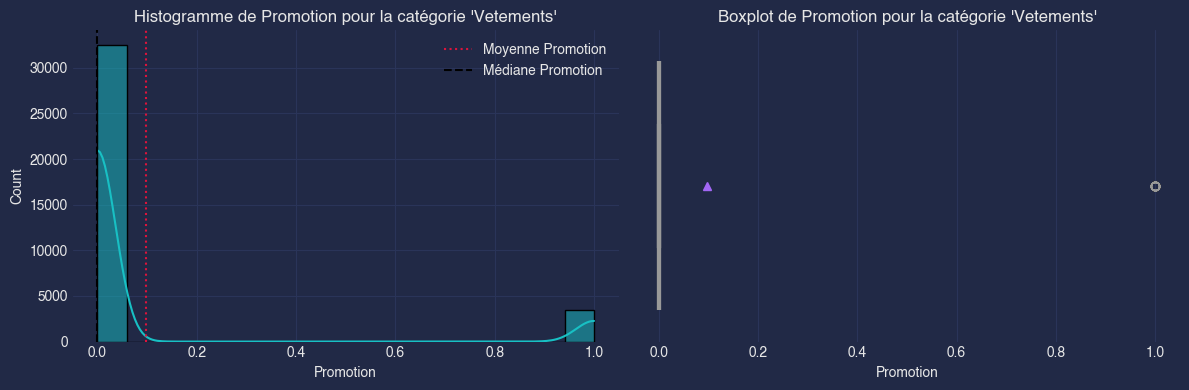



Analyse univariée pour la variable 'QuantiteVendue':
╒════════════════╤═════════╤═══════════╤══════════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════╤════════════╕
│                │   count │      mean │      std │   min │   25% │   50% │   75% │   max │    skew │   kurtosis │
╞════════════════╪═════════╪═══════════╪══════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═════════╪════════════╡
│ QuantiteVendue │   36000 │ 0.0460278 │ 0.256515 │     0 │     0 │     0 │     0 │     6 │ 7.17995 │    67.8661 │
╘════════════════╧═════════╧═══════════╧══════════╧═══════╧═══════╧═══════╧═══════╧═══════╧═════════╧════════════╛


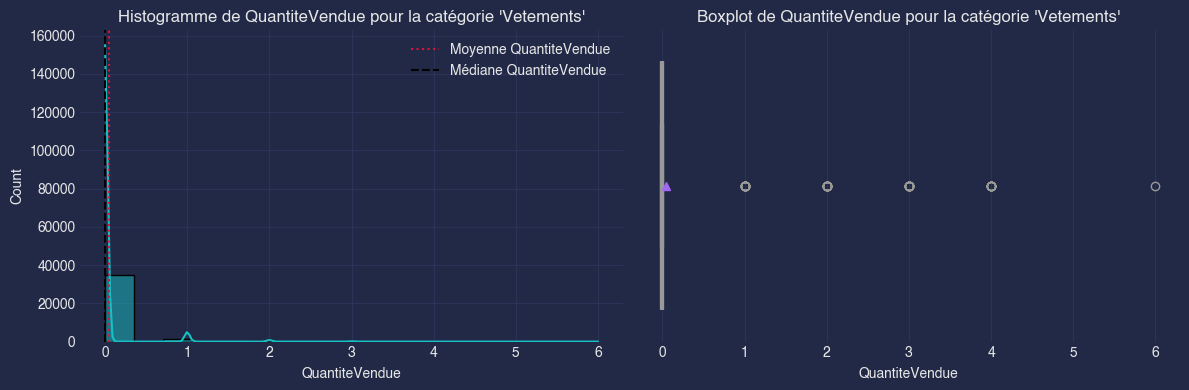



Analyse univariée pour la variable 'ProbabiliteAchat':
╒══════════════════╤═════════╤════════════╤═══════════╤═════════════╤═════════════╤═════════════╤════════════╤══════════╤═════════╤════════════╕
│                  │   count │       mean │       std │         min │         25% │         50% │        75% │      max │    skew │   kurtosis │
╞══════════════════╪═════════╪════════════╪═══════════╪═════════════╪═════════════╪═════════════╪════════════╪══════════╪═════════╪════════════╡
│ ProbabiliteAchat │   36000 │ 0.00944698 │ 0.0292882 │ 3.82946e-08 │ 2.20426e-05 │ 0.000347096 │ 0.00470047 │ 0.614274 │ 6.92961 │    70.5836 │
╘══════════════════╧═════════╧════════════╧═══════════╧═════════════╧═════════════╧═════════════╧════════════╧══════════╧═════════╧════════════╛


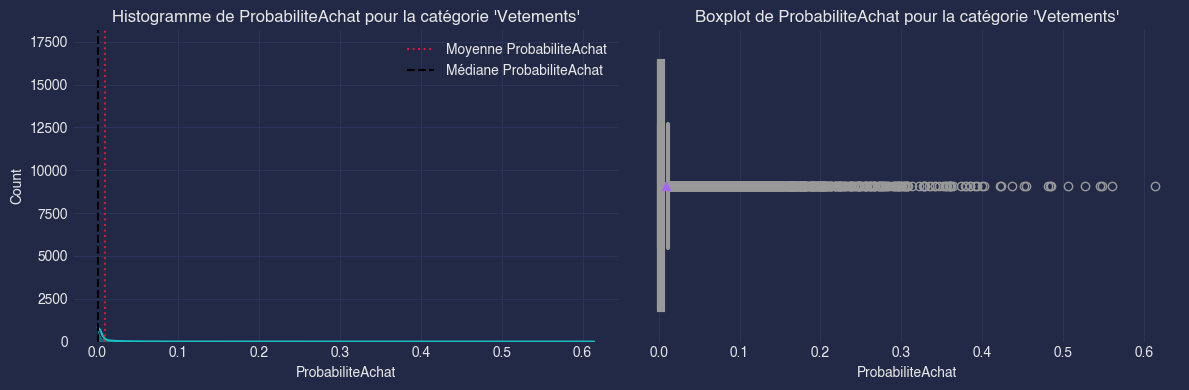



Analyse univariée pour la variable 'UtiliteProduit':
╒════════════════╤═════════╤══════════╤═════════╤═════════╤══════════╤═════════╤══════════╤══════════╤════════════╤════════════╕
│                │   count │     mean │     std │     min │      25% │     50% │      75% │      max │       skew │   kurtosis │
╞════════════════╪═════════╪══════════╪═════════╪═════════╪══════════╪═════════╪══════════╪══════════╪════════════╪════════════╡
│ UtiliteProduit │   36000 │ -8.05249 │ 3.27054 │ -17.078 │ -10.7361 │ -8.0359 │ -5.35576 │ 0.465315 │ -0.0140163 │  -0.973414 │
╘════════════════╧═════════╧══════════╧═════════╧═════════╧══════════╧═════════╧══════════╧══════════╧════════════╧════════════╛


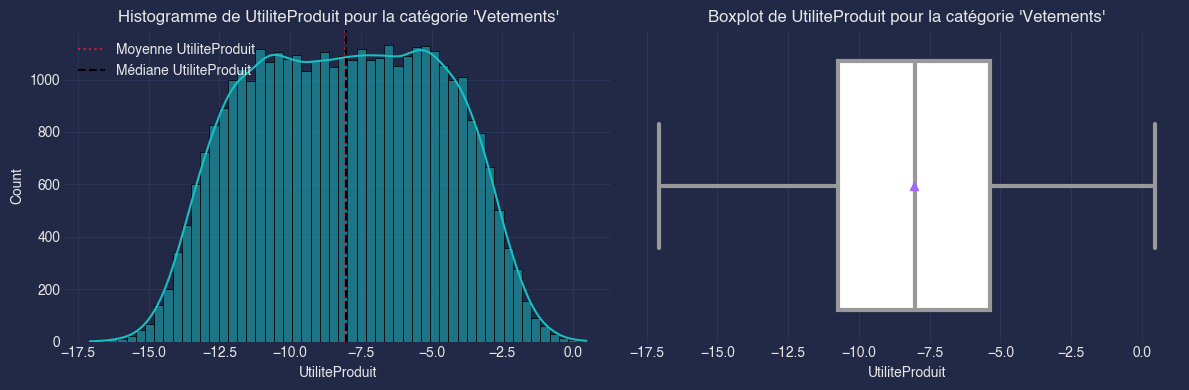



Analyse univariée pour la variable 'ElasticitePrix':
╒════════════════╤═════════╤═══════════╤══════════╤═══════════╤═══════════╤═══════════╤═══════════╤══════════╤══════════╤════════════╕
│                │   count │      mean │      std │       min │       25% │       50% │       75% │      max │     skew │   kurtosis │
╞════════════════╪═════════╪═══════════╪══════════╪═══════════╪═══════════╪═══════════╪═══════════╪══════════╪══════════╪════════════╡
│ ElasticitePrix │   36000 │ 0.0525577 │ 0.001554 │ 0.0204662 │ 0.0528096 │ 0.0530406 │ 0.0530578 │ 0.053059 │ -6.92961 │    70.5836 │
╘════════════════╧═════════╧═══════════╧══════════╧═══════════╧═══════════╧═══════════╧═══════════╧══════════╧══════════╧════════════╛


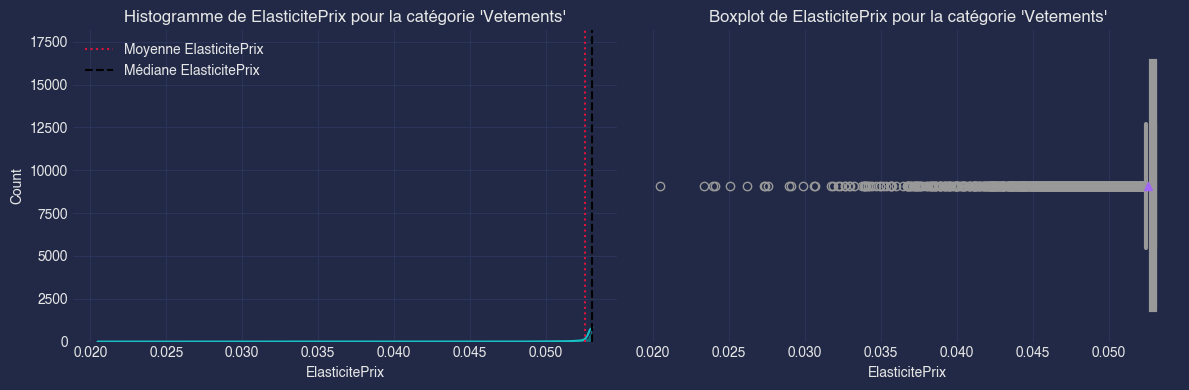



Analyse univariée pour la variable 'Remise':
╒════════╤═════════╤════════════╤═══════════╤═══════╤═══════╤═══════╤═══════╤═══════╤════════╤════════════╕
│        │   count │       mean │       std │   min │   25% │   50% │   75% │   max │   skew │   kurtosis │
╞════════╪═════════╪════════════╪═══════════╪═══════╪═══════╪═══════╪═══════╪═══════╪════════╪════════════╡
│ Remise │   36000 │ 0.00974722 │ 0.0296604 │     0 │     0 │     0 │     0 │   0.1 │ 2.7144 │    5.36824 │
╘════════╧═════════╧════════════╧═══════════╧═══════╧═══════╧═══════╧═══════╧═══════╧════════╧════════════╛


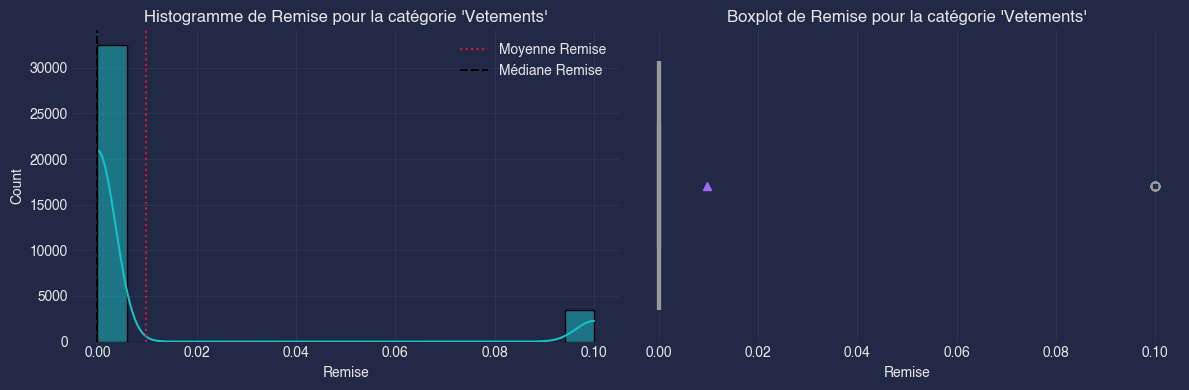



Analyse univariée pour la variable 'Qualite':
╒═════════╤═════════╤══════════╤══════════╤═══════════╤══════════╤══════════╤══════════╤═════════╤═══════════╤════════════╕
│         │   count │     mean │      std │       min │      25% │      50% │      75% │     max │      skew │   kurtosis │
╞═════════╪═════════╪══════════╪══════════╪═══════════╪══════════╪══════════╪══════════╪═════════╪═══════════╪════════════╡
│ Qualite │   36000 │ 0.520973 │ 0.310241 │ 0.0641278 │ 0.224962 │ 0.512718 │ 0.825933 │ 0.96663 │ -0.075176 │   -1.43268 │
╘═════════╧═════════╧══════════╧══════════╧═══════════╧══════════╧══════════╧══════════╧═════════╧═══════════╧════════════╛


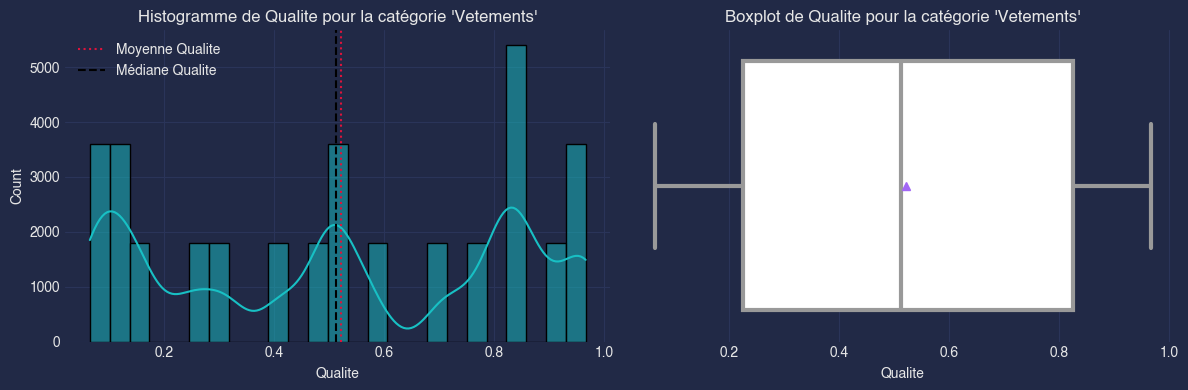

In [10]:
analyse_univariee_par_categorie(df_synth, 'Categorie')

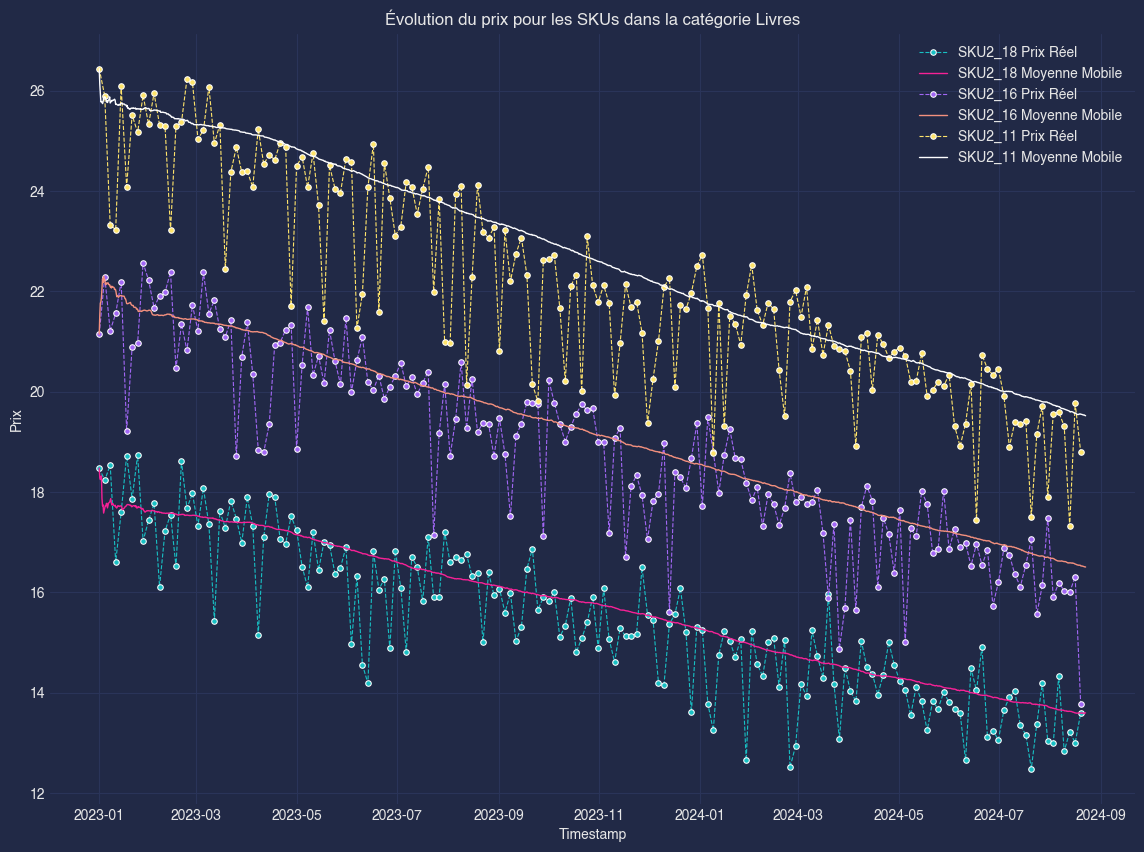

In [11]:
tracer_skus_pour_categorie(df_synth, categorie="Livres", nombre_skus=3)

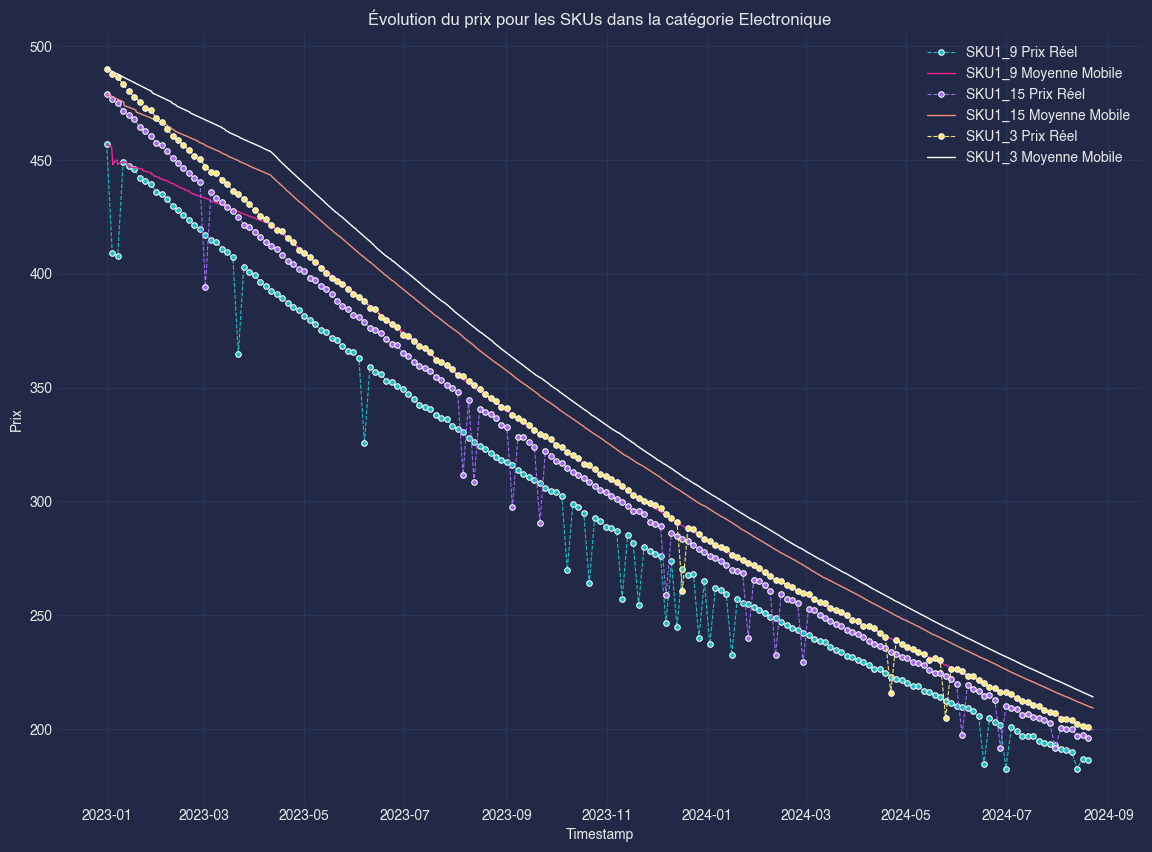

In [12]:
tracer_skus_pour_categorie(df_synth, categorie="Electronique", nombre_skus=3)


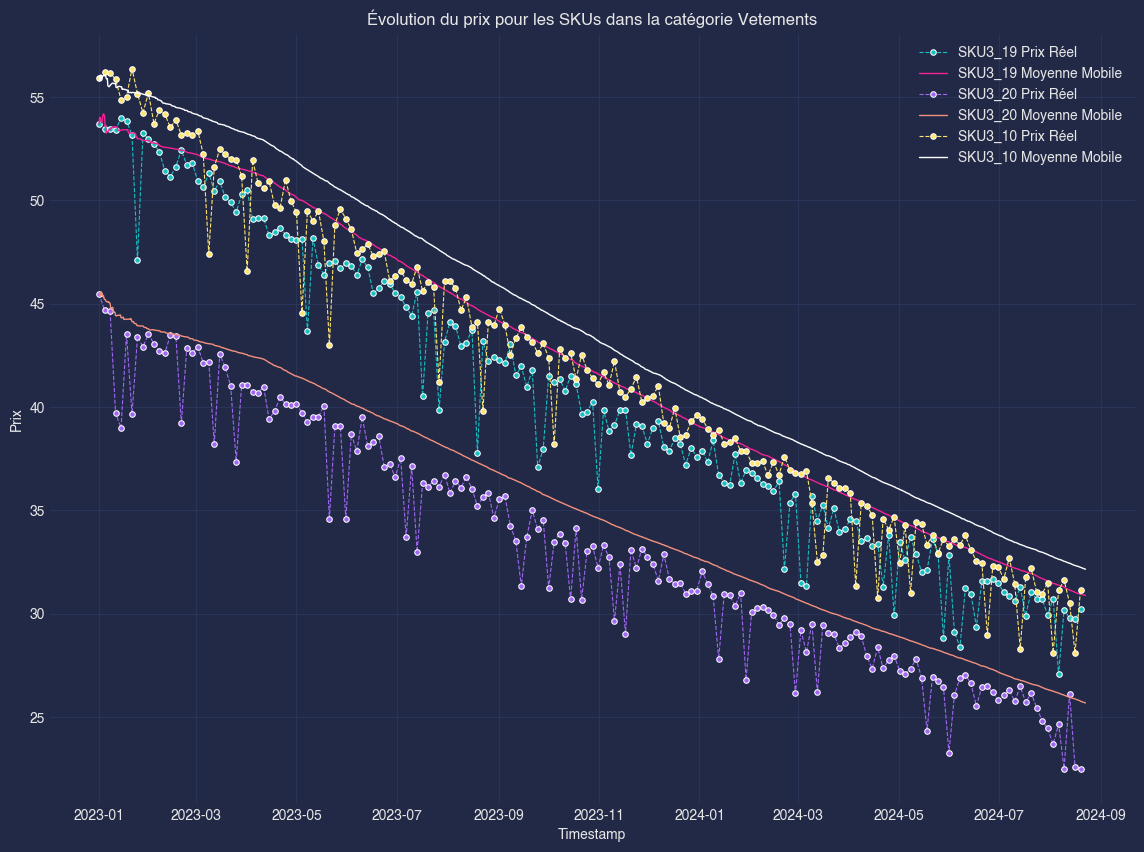

In [13]:
tracer_skus_pour_categorie(df_synth, categorie="Vetements", nombre_skus=3)


## 1.2 **Feature Engineering & Préprocessing**

In [ ]:
# Calcul la répartition en nombre et en pourcentage
table_repartition = df_synth['Categorie'].value_counts().reset_index()
table_repartition.columns = ['Categorie', 'Count']
table_repartition['Percentage'] = (table_repartition['Count'] / table_repartition['Count'].sum()) * 100
table_repartition['Percentage'] = table_repartition['Percentage'].apply(lambda x: f"{x:.2f}%")  # Formater avec le symbole %

# Afficher le tableau
table_repartition

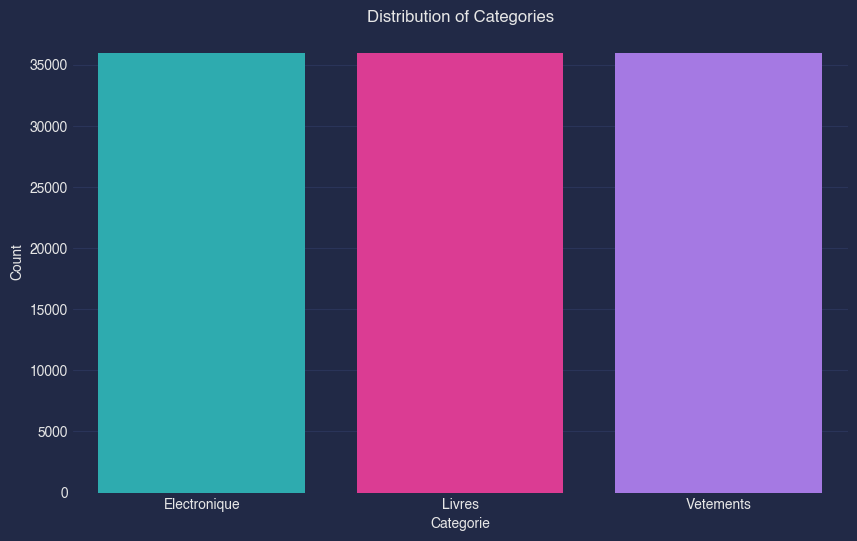

In [14]:
# Plotting the bar plot for the variable 'Categorie'
plt.figure(figsize=(10, 6))
sns.countplot(data=df_synth, x='Categorie', hue='Categorie')
plt.title('Distribution of Categories')
plt.xlabel('Categorie')
plt.ylabel('Count')
plt.show()

In [ ]:
# Conversion de la colonne 'Date' en type datetime.
df_synth['Date'] = pd.to_datetime(df_synth['Date'])
df_validation['Date'] = pd.to_datetime(df_validation['Date'])

In [16]:
# Copie du DataFrame 
df_preprocessed = df_synth.copy()

# Sélection des colonnes catégorielles pour One-Hot Encoding
cat_columns = df_synth.select_dtypes(include=['category']).columns

# Application du One-Hot Encoding sur les colonnes catégorielles pour tous les jeux de données
df_preprocessed = pd.get_dummies(df_synth, columns=cat_columns, drop_first=False)
# Conversion explicite des colonnes encodées en entiers (0 et 1)
encoded_columns = df_preprocessed.filter(like='Categorie_').columns
df_preprocessed[encoded_columns] = df_preprocessed[encoded_columns].astype(int)


In [17]:
# Sélection des colonnes catégorielles pour One-Hot Encoding
cat_columns = df_validation.select_dtypes(include=['category']).columns

# Application du One-Hot Encoding sur les colonnes catégorielles pour tous les jeux de données
df_val_prepro = pd.get_dummies(df_validation, columns=cat_columns, drop_first=False)
# Conversion explicite des colonnes encodées en entiers (0 et 1)
encoded_columns = df_val_prepro.filter(like='Categorie_').columns
df_val_prepro[encoded_columns] = df_val_prepro[encoded_columns].astype(int)


In [19]:
# Transformation des timestamps pour tous les modèles
df_preprocessed['Annee'] = df_preprocessed['Timestamp'].dt.year
df_preprocessed['Mois'] = df_preprocessed['Timestamp'].dt.month
df_preprocessed['Jour'] = df_preprocessed['Timestamp'].dt.day
df_preprocessed['Heure'] = df_preprocessed['Timestamp'].dt.hour

# Variables cycliques pour les modèles linéaires
df_preprocessed['Mois_sin'] = np.sin(2 * np.pi * df_preprocessed['Mois'] / 12)
df_preprocessed['Mois_cos'] = np.cos(2 * np.pi * df_preprocessed['Mois'] / 12)
df_preprocessed['Heure_sin'] = np.sin(2 * np.pi * df_preprocessed['Heure'] / 24)
df_preprocessed['Heure_cos'] = np.cos(2 * np.pi * df_preprocessed['Heure'] / 24)

df_preprocessed.drop('Date', axis=1, inplace=True)

In [20]:
# Transformation des timestamps pour tous les modèles
df_val_prepro['Annee'] = df_val_prepro['Timestamp'].dt.year
df_val_prepro['Mois'] = df_val_prepro['Timestamp'].dt.month
df_val_prepro['Jour'] = df_val_prepro['Timestamp'].dt.day
df_val_prepro['Heure'] = df_val_prepro['Timestamp'].dt.hour

# Variables cycliques pour les modèles linéaires
df_val_prepro['Mois_sin'] = np.sin(2 * np.pi * df_val_prepro['Mois'] / 12)
df_val_prepro['Mois_cos'] = np.cos(2 * np.pi * df_val_prepro['Mois'] / 12)
df_val_prepro['Heure_sin'] = np.sin(2 * np.pi * df_val_prepro['Heure'] / 24)
df_val_prepro['Heure_cos'] = np.cos(2 * np.pi * df_val_prepro['Heure'] / 24)

df_val_prepro.drop('Date', axis=1, inplace=True)

In [22]:
# Transformation de la colonne 'Promotion'
df_preprocessed['Promotion'] = df_preprocessed['Promotion'].astype(int)

# Gestion des valeurs Extremes dans 'ElasticitePrix'
q_low, q_high = df_preprocessed['ElasticitePrix'].quantile([0.01, 0.99])
df_preprocessed['ElasticitePrix'] = np.clip(df_preprocessed['ElasticitePrix'], q_low, q_high)


In [23]:
# Transformation de la colonne 'Promotion'
df_val_prepro['Promotion'] = df_val_prepro['Promotion'].astype(int)

# Gestion des valeurs extremes dans 'ElasticitePrix'
q_low, q_high = df_val_prepro['ElasticitePrix'].quantile([0.01, 0.99])
df_val_prepro['ElasticitePrix'] = np.clip(df_val_prepro['ElasticitePrix'], q_low, q_high)


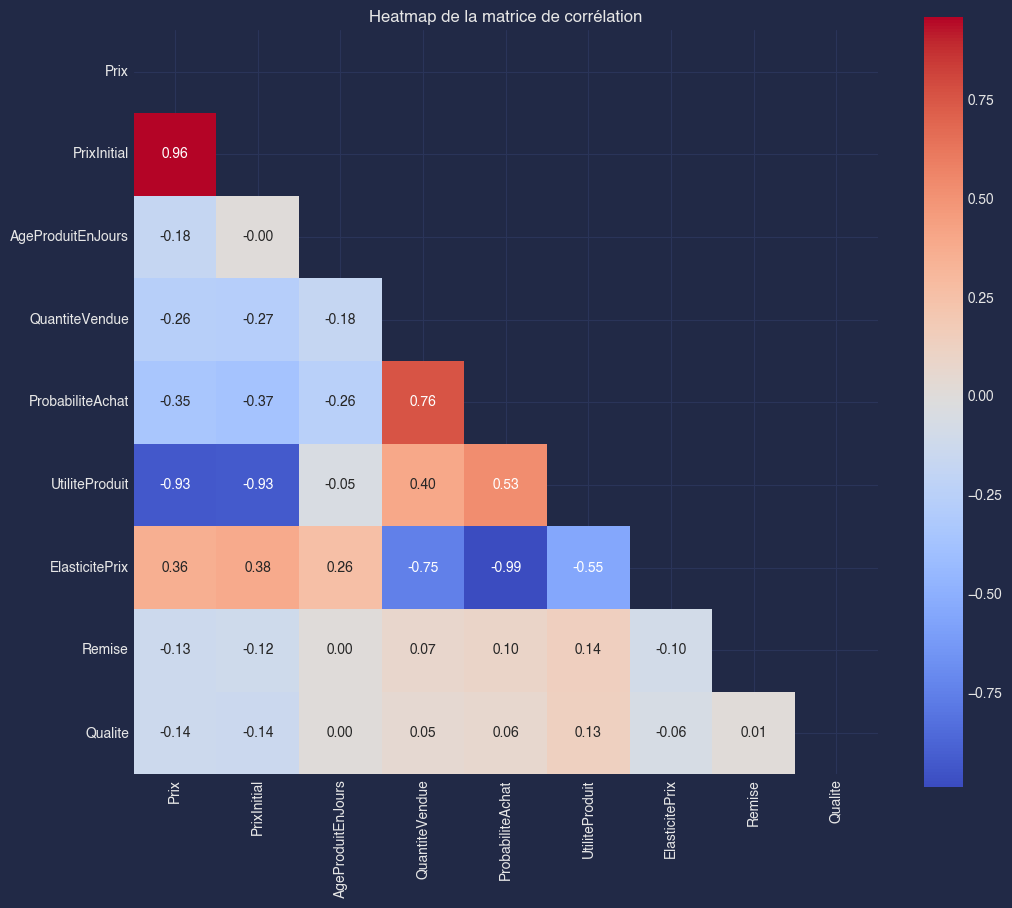

In [25]:
numeric_columns = [
    'Prix', 'PrixInitial', 'AgeProduitEnJours', 
    'QuantiteVendue', 'ProbabiliteAchat', 
    'UtiliteProduit', 'ElasticitePrix', 'Remise', 'Qualite'
]

# Vérification des colonnes réellement présentes dans le DataFrame
numeric_columns = [col for col in numeric_columns if col in df_preprocessed.columns]

# Calcul de la matrice de corrélation pour les colonnes numériques
corr = df_preprocessed[numeric_columns].corr()

# Suppression de la colonne 'Prix' pour analyser uniquement les autres features
# features_corr = corr.drop(columns=['Prix'], errors='ignore')

# Création d'un masque pour masquer la partie supérieure de la matrice
mask = np.triu(np.ones_like(corr, dtype=bool))

# Visualisation de la matrice de corrélation
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', mask=mask, cbar=True, square=True)
plt.title('Heatmap de la matrice de corrélation')
plt.show()


In [26]:
df_preprocessed.drop(columns=['ProbabiliteAchat'], inplace=True)

In [27]:
df_val_prepro.drop(columns=['ProbabiliteAchat'], inplace=True)

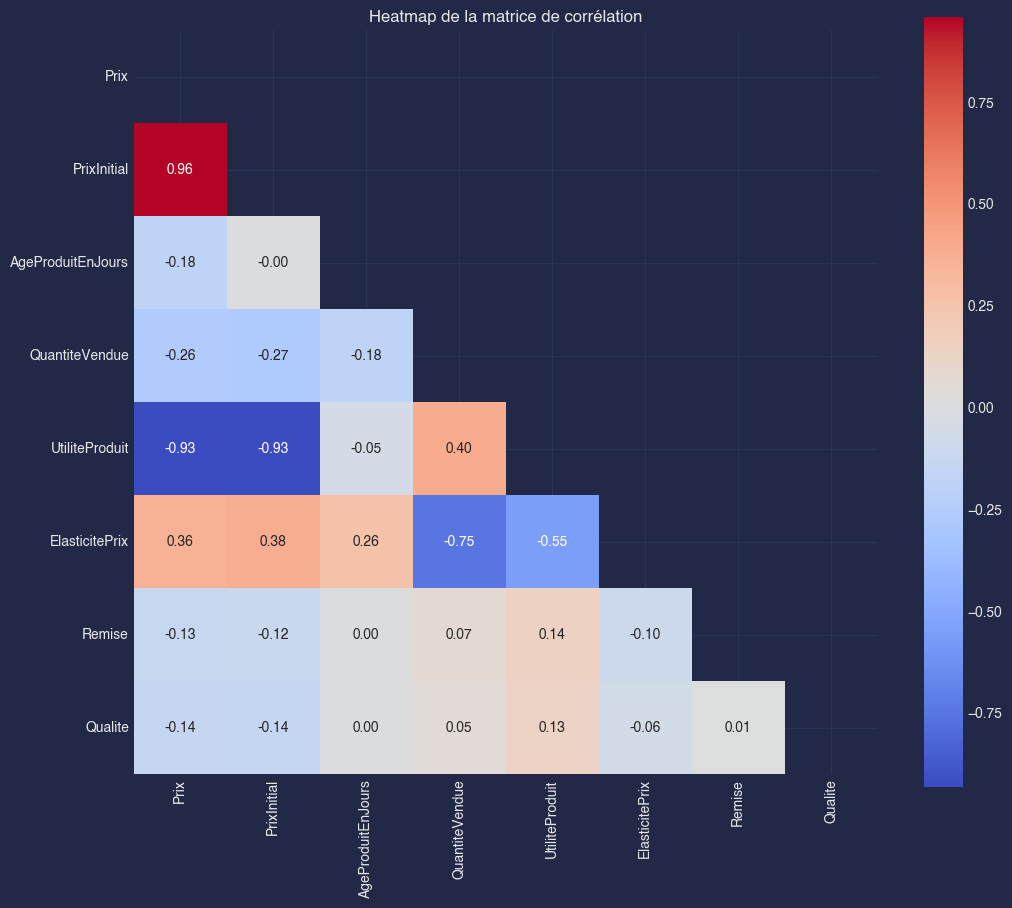

In [29]:
numeric_columns = [
    'Prix', 'PrixInitial', 'AgeProduitEnJours', 
    'QuantiteVendue', 
    'UtiliteProduit', 'ElasticitePrix', 'Remise', 'Qualite'
]

# Vérification des colonnes réellement présentes dans le DataFrame
numeric_columns = [col for col in numeric_columns if col in df_preprocessed.columns]

# Calcul de la matrice de corrélation pour les colonnes numériques
corr = df_preprocessed[numeric_columns].corr()

# Suppression de la colonne 'Prix' pour analyser uniquement les autres features
# features_corr = corr.drop(columns=['Prix'], errors='ignore')

# Création d'un masque pour masquer la partie supérieure de la matrice
mask = np.triu(np.ones_like(corr, dtype=bool))

# Visualisation de la matrice de corrélation
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', mask=mask, cbar=True, square=True)
plt.title('Heatmap de la matrice de corrélation')
plt.show()

In [30]:
# Update numeric_columns by removing the dropped variables
numeric_columns = [col for col in numeric_columns if col in df_preprocessed.columns and col != 'Prix']

# Prepare the features for VIF calculation (exclude the target variable 'Prix')
X = df_preprocessed[numeric_columns]

# Add a constant term for intercept
X = sm.add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Exclude the intercept from the results
vif_data = vif_data[vif_data['Feature'] != 'const']

print(vif_data)


             Feature     VIF
1        PrixInitial  8.6639
2  AgeProduitEnJours  1.0879
3     QuantiteVendue  2.2987
4     UtiliteProduit 10.5898
5     ElasticitePrix  3.2077
6             Remise  1.0224
7            Qualite  1.0209


In [ ]:
directory = "../00 - Annexes/data_prepro/"

# Vérification si le répertoire existe, sinon le créer
if not os.path.exists(directory):
    os.makedirs(directory)

# Sauvegarder les fichiers dans le répertoire nouvellement créé

df_preprocessed.to_csv(directory + "donnees_entrainement_prepro.csv", index=False)
df_val_prepro.to_csv(directory + "donnees_validation_prepro.csv", index=False)
